# Pretrain model

For pretraining we use the first 20 convolutional layers from Figure 3 followed by a average-pooling layer and a fully connected layer.

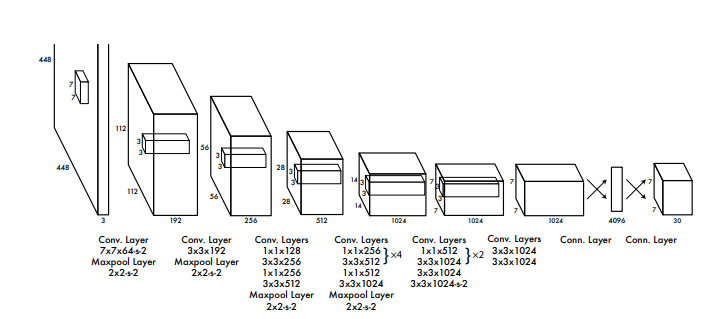

In [70]:
import torch
import torch.nn as nn

In [71]:
# Architecture including convolution layer exclusing fully connected layer
architecture_config = [
    # Each tuple: Kernel_size, output_channels, stride, padding
    (7, 64, 2, 3), # 224 --> 112
    "M", # Max pooling 2x2 of stride 2 (112 --> 56)
    (3, 192, 1, 1), # 56 --> 56
    "M", # 56 --> 28
    (1, 128, 1, 0), # 28 --> 28
    (3, 256, 1, 1), # 28 --> 28
    (1, 256, 1, 0), # 28 --> 28
    (3, 512, 1, 1), # 28 --> 28
    "M", # 28 --> 14
    [(1, 256, 1, 0), (3, 512, 1, 1), 4], # Repeat these two conv layer 4 times (14 --> 14)
    (1, 512, 1, 0), # 14 --> 14
    (3, 1024, 1, 1), # 14 --> 14
    "M", # 14 --> 7
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2], # Repeat these two conv layer 2 times (7 --> 7)
]

In [72]:
class CNNBlock(nn.Module):
  def __init__(self, in_channels, out_channels, **kwargs):
    super(CNNBlock, self).__init__()

    self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
    self.batchnorm = nn.BatchNorm2d(out_channels)
    self.leakyrelu = nn.LeakyReLU(0.1)

  def forward(self, x):
    return self.leakyrelu(self.batchnorm(self.conv(x)))

In [79]:
class Yolov1(nn.Module):
  def __init__(self, in_channels=3, **kwargs):
    super(Yolov1, self).__init__()

    self.architecture = architecture_config
    self.in_channels = in_channels
    self.darknet = self._create_conv_layers(self.architecture)
    self.average = nn.AvgPool2d(kernel_size=1, stride=1)
    self.fcs = self._create_fcs(**kwargs)

  def forward(self, x):
    x = self.darknet(x)
    x = self.average(x)
    return self.fcs(torch.flatten(x, start_dim=1)) # Dimension to flatten is WxHxC, not the batch size so start_dim=1

  def _create_conv_layers(self, architecture):
    layers = []
    in_channels = self.in_channels

    for x in architecture:
      if type(x) == tuple:
        layers += [CNNBlock(in_channels,
                           out_channels=x[1],
                           kernel_size=x[0],
                           stride=x[2],
                           padding=x[3])]

        in_channels = x[1] # Update the in_channels

      elif type(x) == str:
        layers += [nn.MaxPool2d(kernel_size=2, stride=2)]

      elif type(x) == list:
        conv1 = x[0] # Tuple
        conv2 = x[1] # Tuple
        num_repeats = x[2] # Integer

        for _ in range(num_repeats):
          layers += [CNNBlock(in_channels,
                              out_channels = conv1[1],
                              kernel_size = conv1[0],
                              stride = conv1[2],
                              padding = conv1[3])]

          layers += [CNNBlock(in_channels = conv1[1], # Since the out_channels of conv1 is going to be the in_channels of conv2
                              out_channels = conv2[1],
                              kernel_size = conv2[0],
                              stride = conv2[2],
                              padding = conv2[3])]

          in_channels = conv2[1] # Update in_channels

    return nn.Sequential(*layers)

  def _create_fcs(self, split_size, num_boxes, num_classes):
    S, B, C = split_size, num_boxes, num_classes
    return nn.Sequential(
        nn.Flatten(),
        nn.Linear(1024*7*7, S*S*(C+B*5))
    )


In [80]:
# Testing the model
model = Yolov1(split_size=7, num_boxes=2, num_classes=20)
x = torch.randn((2,3,224,224))
print(model(x).shape)

torch.Size([2, 1470])


In [81]:
# Generate the summary of the model
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
summary(model.to(device), (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
         LeakyReLU-3         [-1, 64, 112, 112]               0
          CNNBlock-4         [-1, 64, 112, 112]               0
         MaxPool2d-5           [-1, 64, 56, 56]               0
            Conv2d-6          [-1, 192, 56, 56]         110,592
       BatchNorm2d-7          [-1, 192, 56, 56]             384
         LeakyReLU-8          [-1, 192, 56, 56]               0
          CNNBlock-9          [-1, 192, 56, 56]               0
        MaxPool2d-10          [-1, 192, 28, 28]               0
           Conv2d-11          [-1, 128, 28, 28]          24,576
      BatchNorm2d-12          [-1, 128, 28, 28]             256
        LeakyReLU-13          [-1, 128, 28, 28]               0
         CNNBlock-14          [-1, 128,

# Intersection Over Union

In [48]:
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
  """
  Calculates intersection over union

  Parameters:
    boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
    boxes_labels (tensor): Correct labels of Bounding Boxes (BATCH_SIZE, 4)
    box_format (str): midpoint/ corners, if boxes (x,y,w,h) or (x1, y1, x2, y2)

  Returns:
    tensor: Intersection over union for all examples

  Note:
    The `...` is used for indexing all elements in the preceding dimensions
    and `0:1` represents the range of indices to extract along the last dimension
  """

  if box_format == 'midpoint':
    box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
    box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
    box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
    box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2

    box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
    box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
    box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
    box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

  elif box_format == 'corners':
    box1_x1 = boxes_preds[..., 0:1]
    box1_y1 = boxes_preds[..., 1:2]
    box1_x2 = boxes_preds[..., 2:3]
    box1_y2 = boxes_preds[..., 3:4] # Slicing this way to maintain the shape i.e (N,1) where, N is the number of bboxes

    box2_x1 = boxes_labels[..., 0:1]
    box2_y1 = boxes_labels[..., 1:2]
    box2_x2 = boxes_labels[..., 2:3]
    box2_y2 = boxes_labels[..., 3:4]

  x1 = torch.max(box1_x1, box2_x1)
  y1 = torch.max(box1_y1, box2_y1)
  x2 = torch.max(box1_x2, box2_x2)
  y2 = torch.max(box1_y2, box2_y2)

  # .clamp(0) is for the case when they do not intersect
  intersection = (x2-x1).clamp(0) * (y2-y1).clamp(0) # length * breadth

  box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1)) # Absolute so that area is not negative
  box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1)) # Absolute so that area is not negative

  # IOU = Area of intersection / Area of Union
  return intersection / (box1_area + box2_area - intersection + 1e-6)


# Non Max Supression Algorithm
- Step 1: Start with discarding all bounding boxes < probability threshold
- Step 2: Select the Bounding Box with the largest probability / score
- Step 3: Remove all the other bounding boxes with IoU > threshold

**Note**: Do for each class

In [49]:
def non_max_supression(bboxes, iou_threshold, threshold, box_format="corners"):
  """
  Note: bboxes input should be list of bounding boxes
  i.e bboxes = [[1, 0.9, x1, y1, x2, y2], ..] # Each bounding box --> [class, probability, x1, y1, x2, y2]

  """

  # Validate the input
  assert type(bboxes) == list

  # Discard all the bounding box < probability threshold
  bboxes = [box for box in bboxes if box[1] > threshold]

  # Sort the bboxes in descending order based on their probabilities
  bboxes = sorted(bboxes, key=lambda x:x[1], reverse=True)

  # Create empty list for bboxes to append after NMS
  bboxes_after_nms = []

  while bboxes:
    chosen_box = bboxes.pop(0) # Select and remove the bounding box with largest probability from bboxes list

    # New list comprehension for different class or same class having IoU less than threshold
    bboxes = [
        box
        for box in bboxes
        if box[0] != chosen_box[0] # Checks if the class label of box is different from the class label of chosen_box
        or intersection_over_union(
            torch.tensor(chosen_box[2:]),
            torch.tensor(box[2:]),
            box_format = box_format,
        ) < iou_threshold # Checks if IoU < iou_threshold
    ]

    bboxes_after_nms.append(chosen_box)

  return bboxes_after_nms

# Mean Average Precision

- Step 1:  Get all bounding box predictions on our test set
- Step 2: Sort by **descending confidence score**
- Step 3: Calculate the **Precision** and **Recall** as we go through all outputs
- Step 4: Plot the **Precision-Recall graph**
- Step 5: Calculate Area under **Precision-Recall graph** which is the **average precision** for one class.
- Step 6: Similarly calculate **average precision** for all the other class
- Step 7: Calculate **mAP** i.e sum of all the average pecisions of all the classes / number of classes

Finally, all this was calculated given **specific IoU** threshold of 0.5, we need to redo all computations for many IoUs, example: 0.5, 0.55, 0.6, ..., 0.95. Then **average this** and this will be our **final result**. This is what is meant by mAP@0.5:0.005:0.95 (mAP at 0.5 with a step size of 0.05 upto 0.95).

In [50]:
import torch
from collections import Counter

def mean_average_precision(pred_boxes, true_boxes, iou_threshold=0.5, box_format='midpoint', num_classes=20):
  """
  Note: pred_boxes input should be list of bounding boxes
  i.e pred_boxes = [[train_idx, class_pred, prob_score, x1, y1, x2, y2], ...]

  Similarly for true_boxes
  """

  average_precisions = [] # To store average precisions of each class
  epsilon = 1e-6 # For numerical stability

  for c in range(num_classes):
    detections = []
    ground_truths = []

    for detection in pred_boxes:
      if detection[1] == c:
        detections.append(detection)

    for true_box in true_boxes:
      if true_box[1] == c:
        ground_truths.append(true_box)

    # Calculate the count of unique elements in the ground_truths list and stores the result in the amount_bboxes variable
    # For eg. img 0 has 3 bboxes, img 1 has 5 bboxes then, amount_bboxes = {0:3, 1:5}
    amount_bboxes = Counter([gt[0] for gt in ground_truths])

    for key, val in amount_bboxes.items():
      amount_bboxes[key] = torch.zeros(val)
    # amount_boxes = {0: torch.tensor([0,0,0]), 1: torch.tensor([0,0,0,0,0])}

    # Sort the bboxes in descending order based on their probabilities
    detections.sort(key=lambda x: x[2], reverse=True)

    TP = torch.zeros((len(detections)))
    FP = torch.zeros((len(detections)))
    total_true_bboxes = len(ground_truths)

    # If none exists for this class then we can safely skip
    if total_true_bboxes == 0:
      continue

    for detection_idx, detection in enumerate(detections):
      # Only filter images having same index
      ground_truth_img = [bbox for bbox in ground_truths if bbox[0] == detection[0]]

      num_gts = len(ground_truth_img)
      best_iou = 0

      # For selection of bbox having highest iou
      for idx, gt in enumerate(ground_truth_img):
        iou = intersection_over_union(
            torch.tensor(detection[3:]),
            torch.tensor(gt[3:]),
            box_format = box_format
        )

        if iou > best_iou:
          best_iou = iou
          best_gt_idx = idx

      # Categorizing either TP or FP
      if best_iou > iou_threshold:
        # Check if we haven't covered this bounding box before | '0' means we haven't covered
        if amount_bboxes[detection[0]][best_gt_idx] == 0:
          TP[detection_idx] = 1
          amount_bboxes[detection[0]][best_gt_idx] == 1 # Update that now it's covered
        else:
          FP[detection_idx] = 1
      else:
        FP[detection_idx] = 1

    # [1,1,0,1,0] --> [1,2,2,3,3]
    TP_cumsum = torch.cumsum(TP, dim=0)
    FP_cumsum = torch.cumsum(FP, dim=0)

    recalls = TP_cumsum / (total_true_bboxes + epsilon)
    precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))

    # By adding these initial values of 1 to precisions and 0 to recalls,
    # the code ensures that the precision and recall values start with the appropriate initial points.
    precisions = torch.cat((torch.tensor([1]), precisions))
    recalls = torch.cat((torch.tensor([0]), recalls))

    # Calculate the average precision by using the trapezoidal rule to compute the area under the precision-recall curve
    average_precisions.append(torch.trapz(precisions, recalls))

  # Return mAP
  return sum(average_precisions) / len(average_precisions)


Note: amount_bboxes is done to keep track of the target boounding boxes that we have covered so far. We can't have mutiple prediction bounding boxes for one target bounding box and count them all as correct. Only the first one that covers a target bounding box is correct and the other ones would be false positives.

# Loss Function
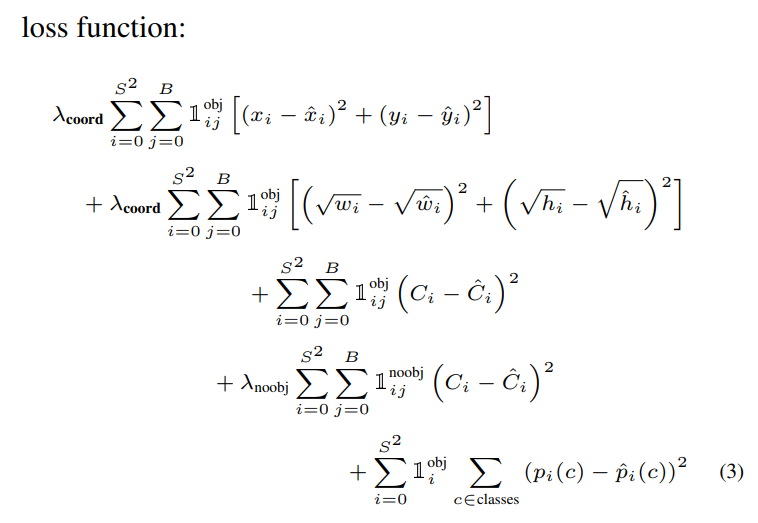

In [51]:
import torch
import torch.nn as nn

class YoloLoss(nn.Module):
  def __init__(self, S=7, B=2, C=20):
    super(YoloLoss, self).__init__()
    self.mse = nn.MSELoss(reduction="sum") # reduction="sum" indicates that the losses will be summed up
    self.S = S
    self.B = B
    self.C = C

    self.lambda_noobj = 0.5
    self.lambda_coord = 5

  def forward(self, predictions, target):
    predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B*5)

    iou_b1 = intersection_over_union(predictions[..., 21:25], target[..., 21:25])
    iou_b2 = intersection_over_union(predictions[..., 26:30], target[..., 21:25])

    ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)
    iou_maxes, bestbox = torch.max(ious, dim=0) # Store the maximum values and corresponding indices, respectively

    # Get the confidence probability and unsqueeze in 3rd dim
    exists_box = target[..., 20].unsqueeze(3) # Tells us if there is an object in cell (i)

    #=======================#
    # FOR BOUNDING BOX LOSS #
    #=======================#
    box_predictions = exists_box * (
        (
          bestbox * predictions[..., 26:30] # if second bbox is the best
          + (1 - bestbox) * predictions[..., 21:25] # if first bbox is the best
        )
    )

    box_targets = exists_box * target[..., 21:25]

    # Taking square root of width and height as required
    box_predictions[...,2:4] = torch.sign(box_predictions[...,2:4]) * torch.sqrt(
        torch.abs(box_predictions[...,2:4] + 1e-6))
    box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

    # Calculate the loss
    # end_dim=-2 indicates that all dimensions except the last two should be flattened because (N,S,S,4) --> (N*S*S, 4)
    box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2))

    #=================#
    # FOR OBJECT LOSS #
    #=================#
    pred_box = (
        bestbox*predictions[..., 25:26] # if second box is best, take its confidence value
        + (1-bestbox)*predictions[..., 20:21] # if first box is best, take its confidence value
    )

    object_loss = self.mse(
        torch.flatten(exists_box * pred_box),
        torch.flatten(exists_box * target[...,20:21])
    )

    #====================#
    # FOR NO OBJECT LOSS #
    #====================#

    # For first bbox
    no_object_loss = self.mse(
        torch.flatten((1 - exists_box) * predictions[...,20:21], start_dim=1), # (N,S,S,1) --> (N, S*S*1)
        torch.flatten((1 - exists_box) * target[...,20:21], start_dim=1)
    )

    # For second bbox
    no_object_loss += self.mse(
        torch.flatten((1 - exists_box) * predictions[...,25:26], start_dim=1),
        torch.flatten((1 - exists_box) * target[...,20:21], start_dim=1)
    )

    #================#
    # FOR CLASS LOSS #
    #================#
    class_loss = self.mse(
        torch.flatten(exists_box * predictions[..., :20], end_dim=-2), # (N,S,S,20)-->(N*S*S, 20)
        torch.flatten(exists_box * target[..., :20], end_dim=-2)
    )

    # ACTUAL LOSS
    loss = (
        self.lambda_coord * box_loss
        + object_loss
        + self.lambda_noobj * no_object_loss
        + class_loss
    )

    return loss


# Plot image

In [52]:
img_labels = {0:'aeroplane',
              1:'bicycle',
              2:'bird',
              3:'boat',
              4:'bottle',
              5:'bus',
              6:'car',
              7:'cat',
              8:'chair',
              9:'cow',
              10:'diningtable',
              11:'dog',
              12:'horse',
              13:'motorbike',
              14:'person',
              15:'pottedplant',
              16:'sheep',
              17:'sofa',
              18:'train',
              19:'tvmonitor'}

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def plot_image(image, boxes):
    """Plots predicted bounding boxes on the image"""
    # Convert input image to numpy array
    im = np.array(image)
    height, width, _ = im.shape

    # Create figure and axes
    fig, ax = plt.subplots(1)
    # Display the image
    ax.imshow(im)

    # box[0] is x midpoint, box[2] is width
    # box[1] is y midpoint, box[3] is height

    # Create a Rectangle patch
    for box in boxes:
        cls = int(box[0])
        prob = box[1]
        box = box[2:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"

        # Calculate the top corner of bounding box
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2

        # Create Rectangle patch
        rect = Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        # Add the patch to the Axes
        ax.add_patch(rect)

        # Add class and probability text
        text = f"{img_labels[cls]}: {prob:.2f}"
        ax.text(
            upper_left_x * width,
            upper_left_y * height - 10,
            text,
            fontsize=10,
            color="r",
            verticalalignment="top",
            bbox={"facecolor": "white", "alpha": 0.7, "pad": 2},
        )

    plt.show()
    return fig

# Get Bounding Box for true and predicted

In [54]:
def get_bboxes(
    loader,
    model,
    iou_threshold,
    threshold,
    pred_format="cells",
    box_format="midpoint",
    device="cuda" if torch.cuda.is_available() else "cpu"):

  """
  Input images --> get all true boxes and predicted boxes
  """

  all_pred_boxes = []
  all_true_boxes = []

  # make sure model is in eval before get bboxes
  model.eval()
  train_idx = 0 # For each image

  for batch_idx, (x, labels) in enumerate(loader):
      x = x.to(device)
      labels = labels.to(device)

      with torch.no_grad():
          predictions = model(x)

      batch_size = x.shape[0]
      true_bboxes = cellboxes_to_boxes(labels)
      bboxes = cellboxes_to_boxes(predictions)

      # For every image in each batch --> NMS
      for idx in range(batch_size):
          nms_boxes = non_max_supression(
              bboxes[idx],
              iou_threshold=iou_threshold,
              threshold=threshold,
              box_format=box_format,
          )

          for nms_box in nms_boxes:
              all_pred_boxes.append([train_idx] + nms_box)

          for box in true_bboxes[idx]:
              # many will get converted to 0 pred
              if box[1] > threshold:
                  all_true_boxes.append([train_idx] + box)

          train_idx += 1

  model.train()
  return all_pred_boxes, all_true_boxes

In [55]:
def convert_cellboxes(predictions, S=7):
    """
    Converts bounding boxes output from Yolo with
    an image split size of S into entire image ratios
    rather than relative to cell ratios.
    """

    # Reshape the prediction and select the best bounding box
    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, 30)
    bboxes1 = predictions[..., 21:25]
    bboxes2 = predictions[..., 26:30]
    scores = torch.cat(
        (predictions[..., 20].unsqueeze(0), predictions[..., 25].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2

    # Converting wrt image ratio
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1) # (batch_size, 7, 7, 1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]

    converted_bboxes = torch.cat((x, y, w_y), dim=-1) # batch_size, 7, 7, 4
    predicted_class = predictions[..., :20].argmax(-1).unsqueeze(-1) # batch_size, 7, 7, 1
    best_confidence = torch.max(predictions[..., 20], predictions[..., 25]).unsqueeze(
        -1
    ) # batch_size, 7, 7, 1
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    return converted_preds # batch_size, 7, 7, 6

In [56]:
def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    # For each image in the batch extract all values from corr. bbox_idx
    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes

# Creating a Dataset

In [57]:
import torch
import os
import pandas as pd
from PIL import Image
import torchvision

class VOCDataset(torch.utils.data.Dataset):
  def __init__(self, csv_file, img_dir, label_dir, S=7, B=2, C=20, transform=None):
    self.annotations = pd.read_csv(csv_file)
    self.img_dir = img_dir
    self.label_dir = label_dir
    self.transform = transform
    self.S = S
    self.B = B
    self.C = C

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self, index):
    label_path = os.path.join(self.label_dir, self.annotations.iloc[index,1])
    boxes = []

    with open(label_path) as f:
      for label in f.readlines():
        # List comprehension that converts each component of the line from string format to either float or integer
        class_label, x, y, width, height = [
            float(x) if float(x) != int(float(x)) else int(x)
            for x in label.replace("\n","").split()
        ]
        # Append bboxes for that particular label
        boxes.append([class_label, x, y, width, height])

    img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])
    image = Image.open(img_path)
    boxes = torch.tensor(boxes)

    if self.transform:
      image = self.transform(image)

    label_matrix = torch.zeros((self.S, self.S, self.C + 5*self.B))
    for box in boxes:
      class_label, x, y, width, height = box.tolist()
      class_label = int(class_label)

      # i=cell row and j=cell column --> get the cell in which midpoint lies
      i , j = int(self.S * y), int(self.S * x)
      # Then again scales down to 0-1
      x_cell, y_cell = self.S * x - j, self.S * y - i
      width_cell, height_cell = (
          width * self.S,
          height * self.S
      )

      # Now fill in the label_matrix
      if label_matrix[i,j,20] == 0: # 20th index specifies if there is object or not
        label_matrix[i,j,20] = 1 # This means that cell has object
        box_coordinates = torch.tensor(
            [x_cell, y_cell, width_cell, height_cell]
        )
        label_matrix[i,j,21:25] = box_coordinates
        label_matrix[i,j,class_label] = 1 # Specifying that particular class is present

    return image, label_matrix

# Load Pascal VOC dataset

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
import zipfile

zip_path = '/content/drive/MyDrive/archive.zip'

with zipfile.ZipFile(zip_path, "r") as zip_ref:
  zip_ref.extractall('/content/data')

In [58]:
import torch
import torchvision.transforms as transforms
import torch.optim as optim
from tqdm import tqdm
import time
from torch.utils.data import DataLoader

seed = 123
torch.manual_seed(seed)

# Hyperparameters
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32
IMG_DIR = '/content/data/images'
LABEL_DIR = '/content/data/labels'

transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

In [59]:
train_dataset = VOCDataset(
    "/content/data/100examples.csv",
    transform=transform,
    img_dir = IMG_DIR,
    label_dir = LABEL_DIR,
)

test_dataset = VOCDataset(
    "/content/data/100examples.csv",
    transform=transform,
    img_dir = IMG_DIR,
    label_dir= LABEL_DIR,
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Training setup and training

In [103]:
# Instantiate the model
model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)

# Compile the model
# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Define the loss function
loss_fn = YoloLoss()

In [104]:
num_epochs = 100

for epoch in tqdm(range(num_epochs), desc='Epochs'):
    model.train()  # Set the model to training mode

    start_time = time.time() # Start time of the epoch

    mean_loss = []

    # Iterate over the training data in batches
    for inputs, labels in train_loader:
        # Move the inputs and labels to the selected device
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward pass
        outputs = model(inputs)

        torch.cuda.empty_cache() # Limit GPU memory growth

        # Calculate the loss
        loss = loss_fn(outputs, labels)
        mean_loss.append(loss.item())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        torch.cuda.empty_cache() # Limit GPU memory growth

    end_time = time.time()  # End time of the epoch
    epoch_duration = end_time - start_time  # Duration of the epoch

    # Use the trained model to predict label
    pred_boxes, target_boxes = get_bboxes(
        train_loader, model, iou_threshold=0.5, threshold=0.4
    )

    # Calculate the mean average precision after every epoch/training
    mean_avg_prec = mean_average_precision(
        pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint"
    )

    if (epoch+1) % 10 == 0:
      # Print the epoch duration
      tqdm.write(f"Epoch {epoch+1} completed in {epoch_duration:.2f} seconds")

      # Print the loss and accuracy for training and validation data
      print(f"Epoch [{epoch+1}/{num_epochs}], "
            f"Loss: {sum(mean_loss)/len(mean_loss):.4f}, mAP: {mean_avg_prec:.4f}")

Epochs:  10%|█         | 10/100 [00:33<04:37,  3.09s/it]

Epoch 10 completed in 1.31 seconds
Epoch [10/100], Loss: 326.5340, mAP: 0.0286


Epochs:  20%|██        | 20/100 [00:59<03:28,  2.60s/it]

Epoch 20 completed in 1.31 seconds
Epoch [20/100], Loss: 218.3506, mAP: 0.8202


Epochs:  30%|███       | 30/100 [01:25<03:04,  2.63s/it]

Epoch 30 completed in 1.32 seconds
Epoch [30/100], Loss: 159.7469, mAP: 0.8003


Epochs:  40%|████      | 40/100 [01:52<02:42,  2.70s/it]

Epoch 40 completed in 1.30 seconds
Epoch [40/100], Loss: 125.2601, mAP: 0.8087


Epochs:  50%|█████     | 50/100 [02:18<02:16,  2.72s/it]

Epoch 50 completed in 1.74 seconds
Epoch [50/100], Loss: 124.5953, mAP: 0.7936


Epochs:  60%|██████    | 60/100 [02:44<01:48,  2.71s/it]

Epoch 60 completed in 1.57 seconds
Epoch [60/100], Loss: 91.9150, mAP: 0.8117


Epochs:  70%|███████   | 70/100 [03:10<01:16,  2.54s/it]

Epoch 70 completed in 1.31 seconds
Epoch [70/100], Loss: 73.9273, mAP: 0.8233


Epochs:  80%|████████  | 80/100 [03:36<00:50,  2.52s/it]

Epoch 80 completed in 1.31 seconds
Epoch [80/100], Loss: 58.9130, mAP: 0.8208


Epochs:  90%|█████████ | 90/100 [04:03<00:25,  2.54s/it]

Epoch 90 completed in 1.31 seconds
Epoch [90/100], Loss: 41.2803, mAP: 0.8154


Epochs: 100%|██████████| 100/100 [04:29<00:00,  2.70s/it]

Epoch 100 completed in 1.31 seconds
Epoch [100/100], Loss: 47.9395, mAP: 0.8162


In [105]:
# Save the model
torch.save(model.state_dict(),'state_dict_model.pth')
torch.save(model, 'model.pth')

# Transfer Learning

In [130]:
import torch
import torch.nn as nn

# Load the pretrained model
pretrained_model = Yolov1(split_size=7, num_boxes=2, num_classes=20)  # Initialize the modified model architecture
pretrained_model.load_state_dict(torch.load('/content/state_dict_model.pth'))

# Remove the last layer
pretrained_model = nn.Sequential(*list(pretrained_model.children())[:-1])

In [131]:
pretrained_model

Sequential(
  (0): Sequential(
    (0): CNNBlock(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.1)
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): CNNBlock(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.1)
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): CNNBlock(
      (conv): Conv2d(192, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.1)
    )
    (5): CNNBlock(

In [132]:
summary(pretrained_model.to(device), (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
         LeakyReLU-3         [-1, 64, 112, 112]               0
          CNNBlock-4         [-1, 64, 112, 112]               0
         MaxPool2d-5           [-1, 64, 56, 56]               0
            Conv2d-6          [-1, 192, 56, 56]         110,592
       BatchNorm2d-7          [-1, 192, 56, 56]             384
         LeakyReLU-8          [-1, 192, 56, 56]               0
          CNNBlock-9          [-1, 192, 56, 56]               0
        MaxPool2d-10          [-1, 192, 28, 28]               0
           Conv2d-11          [-1, 128, 28, 28]          24,576
      BatchNorm2d-12          [-1, 128, 28, 28]             256
        LeakyReLU-13          [-1, 128, 28, 28]               0
         CNNBlock-14          [-1, 128,

In [133]:
# Add new layers with random weights
new_layers = nn.Sequential(
    nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.1),

    nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.1),

    nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.1),

    nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.1),

    nn.Flatten(),

    nn.Linear(1024*7*7, 4096),
    nn.LeakyReLU(0.1),

    nn.Linear(4096, 1470)
)

pretrained_model.add_module('new_layers', new_layers)


In [134]:
pretrained_model

Sequential(
  (0): Sequential(
    (0): CNNBlock(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.1)
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): CNNBlock(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.1)
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): CNNBlock(
      (conv): Conv2d(192, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.1)
    )
    (5): CNNBlock(

In [135]:

# Freeze the weights of the pretrained model
for param in pretrained_model.parameters():
    param.requires_grad = False

# Enable gradient computation for the added layers
for param in pretrained_model.new_layers.parameters():
    param.requires_grad = True

In [136]:
summary(pretrained_model.to(device), (3,448,448))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           9,408
       BatchNorm2d-2         [-1, 64, 224, 224]             128
         LeakyReLU-3         [-1, 64, 224, 224]               0
          CNNBlock-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 192, 112, 112]         110,592
       BatchNorm2d-7        [-1, 192, 112, 112]             384
         LeakyReLU-8        [-1, 192, 112, 112]               0
          CNNBlock-9        [-1, 192, 112, 112]               0
        MaxPool2d-10          [-1, 192, 56, 56]               0
           Conv2d-11          [-1, 128, 56, 56]          24,576
      BatchNorm2d-12          [-1, 128, 56, 56]             256
        LeakyReLU-13          [-1, 128, 56, 56]               0
         CNNBlock-14          [-1, 128,

# Use pretrained model for object detection
- Detection often requires fine-grained visual information so we increase the input resolution of the network
from 224 × 224 to 448 × 448.

In [137]:
transform = transforms.Compose([transforms.Resize((448, 448)), transforms.ToTensor()])

train_dataset = VOCDataset(
    "/content/data/100examples.csv",
    transform=transform,
    img_dir = IMG_DIR,
    label_dir = LABEL_DIR,
)

test_dataset = VOCDataset(
    "/content/data/100examples.csv",
    transform=transform,
    img_dir = IMG_DIR,
    label_dir= LABEL_DIR,
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [138]:
# Compile the model
# Define the optimizer
optimizer = optim.Adam(pretrained_model.parameters(), lr=LEARNING_RATE)

# Define the loss function
loss_fn = YoloLoss()

In [139]:
num_epochs = 200

for epoch in tqdm(range(num_epochs), desc='Epochs'):
    pretrained_model.train()  # Set the model to training mode

    start_time = time.time() # Start time of the epoch

    mean_loss = []

    # Iterate over the training data in batches
    for inputs, labels in train_loader:
        # Move the inputs and labels to the selected device
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward pass
        outputs = pretrained_model(inputs)

        torch.cuda.empty_cache() # Limit GPU memory growth

        # Calculate the loss
        loss = loss_fn(outputs, labels)
        mean_loss.append(loss.item())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        torch.cuda.empty_cache() # Limit GPU memory growth

    end_time = time.time()  # End time of the epoch
    epoch_duration = end_time - start_time  # Duration of the epoch

    # Use the trained model to predict label
    pred_boxes, target_boxes = get_bboxes(
        train_loader, pretrained_model, iou_threshold=0.5, threshold=0.4
    )

    # Calculate the mean average precision after every epoch/training
    mean_avg_prec = mean_average_precision(
        pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint"
    )

    if (epoch+1) % 10 == 0:
      # Print the epoch duration
      tqdm.write(f"Epoch {epoch+1} completed in {epoch_duration:.2f} seconds")

      # Print the loss and accuracy for training and validation data
      print(f"Epoch [{epoch+1}/{num_epochs}], "
            f"Loss: {sum(mean_loss)/len(mean_loss):.4f}, mAP: {mean_avg_prec:.4f}")

Epochs:   5%|▌         | 10/200 [00:43<13:44,  4.34s/it]

Epoch 10 completed in 2.26 seconds
Epoch [10/200], Loss: 112.7718, mAP: 0.5975


Epochs:  10%|█         | 20/200 [01:36<14:23,  4.80s/it]

Epoch 20 completed in 2.26 seconds
Epoch [20/200], Loss: 48.6829, mAP: 0.8390


Epochs:  15%|█▌        | 30/200 [02:21<12:30,  4.41s/it]

Epoch 30 completed in 2.26 seconds
Epoch [30/200], Loss: 39.4033, mAP: 0.8444


Epochs:  20%|██        | 40/200 [03:07<12:33,  4.71s/it]

Epoch 40 completed in 2.44 seconds
Epoch [40/200], Loss: 21.8500, mAP: 0.8306


Epochs:  25%|██▌       | 50/200 [03:53<11:22,  4.55s/it]

Epoch 50 completed in 2.45 seconds
Epoch [50/200], Loss: 39.8985, mAP: 0.8103


Epochs:  30%|███       | 60/200 [04:39<10:26,  4.48s/it]

Epoch 60 completed in 2.27 seconds
Epoch [60/200], Loss: 18.8040, mAP: 0.8222


Epochs:  35%|███▌      | 70/200 [05:25<10:08,  4.68s/it]

Epoch 70 completed in 2.30 seconds
Epoch [70/200], Loss: 26.3543, mAP: 0.8241


Epochs:  40%|████      | 80/200 [06:11<09:12,  4.60s/it]

Epoch 80 completed in 2.67 seconds
Epoch [80/200], Loss: 29.7260, mAP: 0.8306


Epochs:  45%|████▌     | 90/200 [06:56<08:19,  4.54s/it]

Epoch 90 completed in 2.31 seconds
Epoch [90/200], Loss: 20.7433, mAP: 0.8332


Epochs:  50%|█████     | 100/200 [07:41<07:23,  4.43s/it]

Epoch 100 completed in 2.28 seconds
Epoch [100/200], Loss: 19.9015, mAP: 0.8163


Epochs:  55%|█████▌    | 110/200 [08:27<06:57,  4.64s/it]

Epoch 110 completed in 2.70 seconds
Epoch [110/200], Loss: 18.1376, mAP: 0.8377


Epochs:  60%|██████    | 120/200 [09:12<06:03,  4.54s/it]

Epoch 120 completed in 2.33 seconds
Epoch [120/200], Loss: 14.9192, mAP: 0.8175


Epochs:  65%|██████▌   | 130/200 [09:57<05:11,  4.45s/it]

Epoch 130 completed in 2.29 seconds
Epoch [130/200], Loss: 12.4262, mAP: 0.8155


Epochs:  70%|███████   | 140/200 [10:44<04:41,  4.68s/it]

Epoch 140 completed in 2.33 seconds
Epoch [140/200], Loss: 17.0479, mAP: 0.7979


Epochs:  75%|███████▌  | 150/200 [11:29<03:49,  4.60s/it]

Epoch 150 completed in 2.61 seconds
Epoch [150/200], Loss: 9.0079, mAP: 0.8070


Epochs:  80%|████████  | 160/200 [12:15<02:59,  4.49s/it]

Epoch 160 completed in 2.29 seconds
Epoch [160/200], Loss: 11.4750, mAP: 0.8310


Epochs:  85%|████████▌ | 170/200 [13:01<02:15,  4.53s/it]

Epoch 170 completed in 2.28 seconds
Epoch [170/200], Loss: 9.7192, mAP: 0.8390


Epochs:  90%|█████████ | 180/200 [13:46<01:31,  4.60s/it]

Epoch 180 completed in 2.83 seconds
Epoch [180/200], Loss: 12.5288, mAP: 0.8179


Epochs:  95%|█████████▌| 190/200 [14:31<00:44,  4.50s/it]

Epoch 190 completed in 2.28 seconds
Epoch [190/200], Loss: 8.7870, mAP: 0.8394


Epochs: 100%|██████████| 200/200 [15:16<00:00,  4.58s/it]

Epoch 200 completed in 2.30 seconds
Epoch [200/200], Loss: 8.8527, mAP: 0.8004


In [140]:
# Save this model after transfer learning
torch.save(pretrained_model.state_dict(),'transfer_learning_model.pth')

# Testing for unseen image

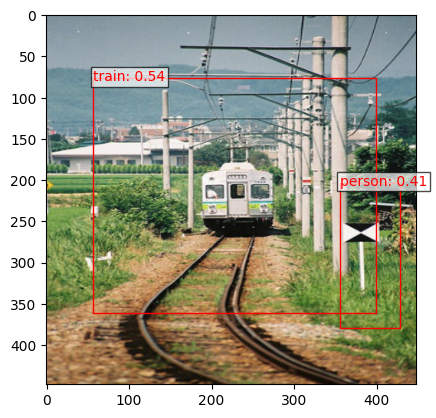

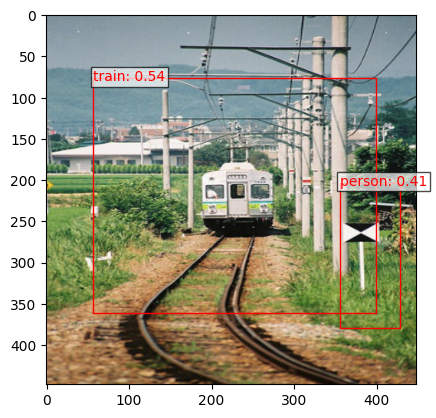

In [142]:
import torch
from torchvision import transforms
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

pretrained_model.eval()
pretrained_model = pretrained_model.to(device)

# Test for each image
image_path = "data/images/000002.jpg"
image = Image.open(image_path)

# Transform the image
transform = transforms.Compose([transforms.Resize((448, 448)), transforms.ToTensor()])
image = transform(image).unsqueeze(0)
image = image.to(device)

# Forward pass
with torch.no_grad():
    output = pretrained_model(image)

# Get bboxes by predicting bboxes for given image
bboxes = cellboxes_to_boxes(output)

# Remove multiple bboxes for same object
bboxes = non_max_supression(bboxes[0], iou_threshold=0.5, threshold=0.4, box_format="midpoint")

# Plot the image with bboxes
plot_image(image[0].permute(1,2,0).to('cpu'), bboxes)

# Testing for seen image

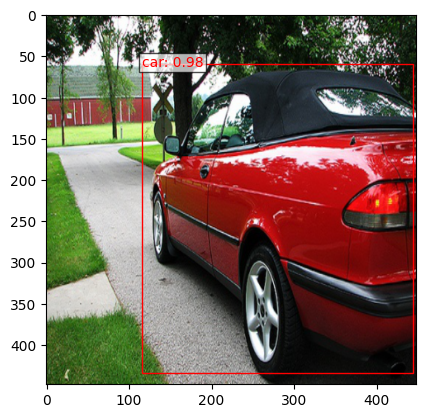

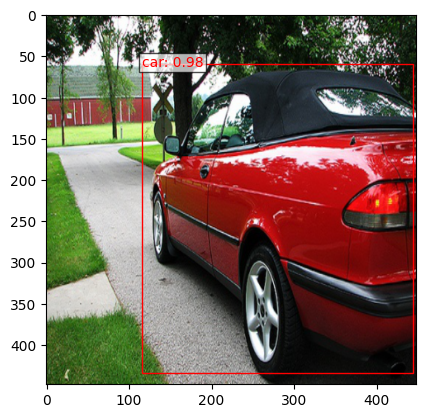

In [143]:
import torch
from torchvision import transforms
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

pretrained_model.eval()
pretrained_model = pretrained_model.to(device)

# Test for each image
image_path = "data/images/000007.jpg"
image = Image.open(image_path)

# Transform the image
transform = transforms.Compose([transforms.Resize((448, 448)), transforms.ToTensor()])
image = transform(image).unsqueeze(0)
image = image.to(device)

# Forward pass
with torch.no_grad():
    output = pretrained_model(image)

# Get bboxes by predicting bboxes for given image
bboxes = cellboxes_to_boxes(output)

# Remove multiple bboxes for same object
bboxes = non_max_supression(bboxes[0], iou_threshold=0.5, threshold=0.4, box_format="midpoint")

# Plot the image with bboxes
plot_image(image[0].permute(1,2,0).to('cpu'), bboxes)